In [1]:
import sys
sys.path.insert(1, '..')

In [2]:
import os    
import copy
import csv
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import MultiStepLR

from model import EfficientNet_B0
# from efficientnet_pytorch import EfficientNet

%load_ext autoreload
%autoreload 2

In [3]:
os.listdir('../data')

['cifar-10-batches-py', 'cifar-10-python.tar.gz']

In [4]:
batch = 256

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def train_cifar(classifier, optimizer, scheduler, trainloader, testloader, name, epochs=100, print_freq=1, device=None):
    # save model
    best_epoch = 0
    best_loss = 999
    best_weights = copy.deepcopy(classifier.state_dict())
    
    save_dir = '../saved_models/' + name + '/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
    train_losses = []
    test_losses = []
    test_acc = []
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        #training
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()*len(inputs)
        running_loss = running_loss/50000
        
        #testing
        correct = 0
        total = 0
        test_loss = 0
        for data in testloader:
            with torch.no_grad():
                images, labels = data[0].to(device), data[1].to(device)
                outputs = classifier(images)
                test_loss += loss.item()*len(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_loss = test_loss/10000
        
        train_losses.append(running_loss)
        test_losses.append(test_loss)
        test_acc.append(correct/total)
        #test every 'print_freq' epochs
        if epoch % print_freq == 0:
            print(f'epoch: {epoch+1}/{epochs}, train loss: {train_losses[-1]:.4f}, test loss: {test_losses[-1]:.4f}, test acc: {correct/total:.4f}')
    
     
        if best_loss < test_loss:
            best_loss = test_loss
            best_weights = copy.deepcopy(classifier.state_dict())
            best_epoch = epoch
        # update scheduler
#         scheduler.step()
        
    torch.save(best_weights, os.path.join(save_dir, 'best.pth'))
    print('best epoch: {}'.format(best_epoch))
    
    classifier.load_state_dict(best_weights)
    
    return train_losses, test_losses, test_acc, classifier

In [6]:
def plot_history(train_losses,test_losses,test_acc,saveto):
    # Plot the loss function and train / validation accuracies
    plt.figure(figsize=(8,10))
    plt.subplot(2, 1, 1)
    plt.plot(train_losses,label='train')
    plt.plot(test_losses,label='test')
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(test_acc, label='train')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Classification accuracy')
    plt.show()
    plt.savefig(saveto)

# EfficientNet-B0

epoch: 1/3, train loss: 2.4600, test loss: 2.0202, test acc: 0.2569
epoch: 2/3, train loss: 1.8756, test loss: 1.7525, test acc: 0.3481
epoch: 3/3, train loss: 1.6610, test loss: 1.6118, test acc: 0.4126
best epoch: 0


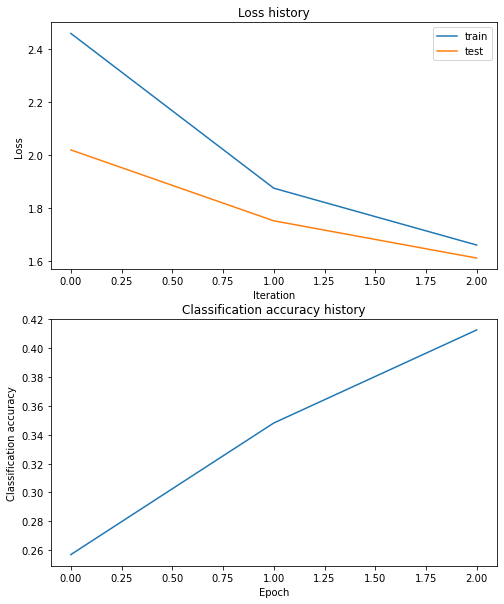

<Figure size 432x288 with 0 Axes>

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classifier = EfficientNet_B0().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
train_losses, test_losses, test_acc, classifier = train_cifar(classifier, optimizer, scheduler, trainloader, testloader,
                                                    'EfficientNet-B0', epochs=3, print_freq=1)
# write losses to CSV file
file_path = '../save_loss/EfficientNet_B0_loss' + '.csv'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
solution_rows = [('train_losses', 'test_losses', 'test_acc')] + [(y, test_losses[i], test_acc[i]) for (i, y) in enumerate(train_losses)]
with open(file_path, 'w', newline="") as f:
    writer = csv.writer(f)
    writer.writerows(solution_rows)
        
plot_history(train_losses, test_losses, test_acc, saveto='../save_plot/EfficientNet-B0.png')



# ResNet-18

In [ ]:
classifier = models.resnet18(pretrained=False)
classifier.fc = nn.Linear(512, len(classes))
classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

train_losses, test_losses, test_acc, classifier = train_cifar(classifier, optimizer, scheduler, trainloader, testloader,
                                                   'ResNet-18', epochs=100, print_freq=1)
# write losses to CSV file
file_path = '../save_loss/ResNet18_loss' + '.csv'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
solution_rows = [('train_losses', 'test_losses', 'test_acc')] + [(y, test_losses[i], test_acc[i]) for (i, y) in enumerate(train_losses)]
with open(file_path, 'w', newline="") as f:
    writer = csv.writer(f)
    writer.writerows(solution_rows)

plot_history(train_losses, test_losses, test_acc, saveto='../save_plot/ResNet-18.png')

epoch: 1/100, train loss: 1.7976, test loss: 1.5281, test acc: 0.4463
